# Statistical modeling of sea level along the coast of the Netherlands using Generalized Additive Model (GAM)


__Note on the environment required to run the notebook:__

An installation of Python 3.9 with recent versions of the libraries (numpy, scipy, matplotlib, pandas, xarray, statsmodels, spectrum) should run this Notebook wihout modification.

__Note on running the notebook:__

The computation of the uncertainty range can be rather heavy so it is advised to reduce the bootstrap samples from 1000 to 100 to first make sure the code works and then increase it back to 1000.

In [2]:
# import libraries

import numpy as np
from numpy.polynomial import Polynomial

from scipy.stats import linregress, norm, pearsonr
from scipy.signal import detrend
import scipy.fft as fft
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
import spectrum as sp

In [3]:
# For higher resolution images on retina display screens
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')


## Define fixed data

In [2]:
# Set paths
path_data = '/Users/dewilebars/Projects/SLBudget/data/'
path_era5_data = f'{path_data}/WindPressure/ERA5/'
path_20cr_data = f'{path_data}/WindPressure/20CR/'

# Method to constrain the BSpline smoothing. 
# The character is only used for figures.
# m1 for constrained by degrees of freedom
# m2 for constrained by penalisation weights
method = 'm2'

# Define window in years for rate computation, should be an even number
lag = 2

## Choose a region
The notebook was only tested for the Netherlands and Belgium but other regions can be defined here using the tide gauge ids used by the PSMSL data.

For the Netherlands the six main tide gauge with reliable data since 1890 are used.
For Belgium three tide gauges are used (Nieuwpoort, Oostende, Zeebrugge), unfortunately they only have data since 1967.

In [5]:
region = 'Netherlands'

if region == 'Netherlands':
    tg_id = [20, 22, 23, 24, 25, 32]
elif region == 'Belgium':
    tg_id = [489, 413, 470]

## Read tide gauge data and compute the average

In [6]:
def tide_gauge_obs(tg_id=[20, 22, 23, 24, 25, 32], interp=False):
    '''Read a list of tide gauge data and compute the average. 
    Set interp to True for a linear interpollation of missing values.
    By default use the 6 tide gauges from the Zeespiegelmonitor.
    The unit of the output is cm.''' 
    
    tg_data_dir = path_data + 'rlr_annual'
    names_col = ('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality')
    filelist_df = pd.read_csv(tg_data_dir + '/filelist.txt', sep=';', 
                              header=None, names=names_col)
    filelist_df = filelist_df.set_index('id')

    names_col2 = ('time', 'height', 'interpolated', 'flags')

    for i in range(len(tg_id)):
        tg_data = pd.read_csv(f'{tg_data_dir}/data/{tg_id[i]}.rlrdata', 
                              sep=';', header=None, names=names_col2)
        tg_data = tg_data.set_index('time')
        tg_data.height = tg_data.height.where(~np.isclose(tg_data.height,-99999))
        tg_data.height = tg_data.height - tg_data.height.mean()

        if i==0:
            tg_data_df = pd.DataFrame(data=dict(time=tg_data.index, 
                                                col_name=tg_data.height))
            tg_data_df = tg_data_df.set_index('time')
            tg_data_df.columns  = [str(tg_id[i])] 
        else:
            tg_data_df[str(tg_id[i])] = tg_data.height

    if interp:
        tg_data_df = tg_data_df.interpolate(method='slinear')
        
    tg_data_df['Average'] = tg_data_df.mean(axis=1)
    tg_data_df = tg_data_df * 0.1 # Convert from mm to cm
    
    return tg_data_df

In [7]:
tg_df = tide_gauge_obs(tg_id, interp=True)

if region == 'Netherlands':
    tg_df = tg_df.loc[1890:] # Select years after 1890 as in the Zeespiegelmonitor
elif region == 'Belgium':
    tg_df = tg_df.loc[1967:] # Only from 1967 the 3 tide gauges have data

nt = len(tg_df.index)    

tg_df

,20,22,23,24,25,32,Average
time,,,,,,,
1890,-13.347799,-14.324841,-9.107692,-13.196154,-9.517308,-15.295973,-12.464961
1891,-16.147799,-13.824841,-5.707692,-10.796154,-7.517308,-11.395973,-10.898294
1892,-16.047799,-10.724841,-5.607692,-10.796154,-6.617308,-8.095973,-9.648294
1893,-13.447799,-11.524841,-3.607692,-6.396154,-4.917308,-3.395973,-7.214961
1894,-8.547799,-12.624841,-3.807692,-9.696154,-4.517308,-3.895973,-7.181628
...,...,...,...,...,...,...,...
2016,14.852201,18.575159,11.692308,16.303846,12.782692,14.004027,14.701706
2017,16.452201,20.775159,15.592308,22.103846,17.382692,17.004027,18.218372
2018,11.952201,14.975159,8.892308,12.403846,7.182692,10.204027,10.935039


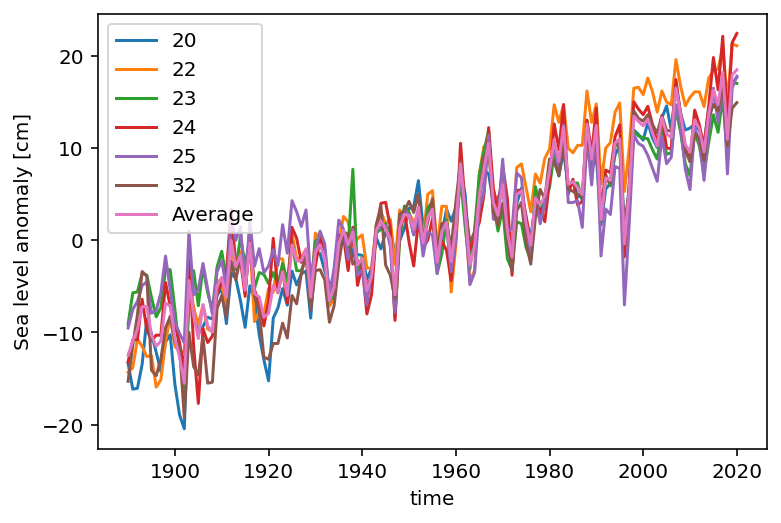

In [8]:
tg_df.plot()
plt.ylabel('Sea level anomaly [cm]');


## Compute wind impact on sea level

20CR wind pseudo-stress data are bias-corrected (relative to ERA5) by a componentwise linear scaling. The scaling is determined from the overlapping data (1950-2015) by matching means and variances.


In [9]:
def combine_linear_scaling(d20CR, dERA5, date_s, date_e):
    
    d20CR_cor = d20CR.copy()
    
    d20CR_cor = d20CR - d20CR.loc[date_s:date_e].mean()
    d20CR_cor = d20CR_cor*dERA5.loc[date_s:date_e].std()/d20CR_cor.loc[date_s:date_e].std()
    d20CR_cor = d20CR_cor + dERA5.loc[date_s:date_e].mean()

    combined_df = pd.concat([d20CR_cor.loc[:1949], dERA5.loc[1950:]])
    
    return combined_df

In [10]:
def read_wind_np(tgi):
    '''Read wind info for the two reanalysis files and combine them'''
    
    wind_info_20CR = pd.read_csv(f'./outputs/wind_data_20CR_tg{tgi}.csv')
    wind_info_20CR = wind_info_20CR.set_index('t')

    wind_info_ERA5 = pd.read_csv(f'./outputs/wind_data_ERA5_tg{tgi}.csv')
    wind_info_ERA5 = wind_info_ERA5.set_index('t')

    combined_df = combine_linear_scaling(wind_info_20CR[['u2','v2']], wind_info_ERA5[['u2','v2']], 1950, 2015)
    
    combined_df.index.rename('time', inplace=True)
    combined_df.rename(columns = {'u2' : f'u2_{tgi}', 'v2' : f'v2_{tgi}'}, inplace=True)
    
    return combined_df

In [11]:
for idx, tgi in enumerate(tg_id):
    
    if idx == 0:
        nearest_point_df = read_wind_np(tgi)
    else:
        nearest_point_df = nearest_point_df.join(read_wind_np(tgi), how='inner')
    
nearest_point_df['u2_mean'] = nearest_point_df.filter(regex='u2_').mean(axis=1)
nearest_point_df['v2_mean'] = nearest_point_df.filter(regex='v2_').mean(axis=1)

nearest_point_df

,u2_20,v2_20,u2_22,v2_22,u2_23,v2_23,u2_24,v2_24,u2_25,v2_25,u2_32,v2_32,u2_mean,v2_mean
time,,,,,,,,,,,,,,
1836,6.372364,1.366336,5.866997,0.365787,6.569092,-0.218389,2.379316,0.796388,5.490584,0.041950,7.553453,0.870614,5.705301,0.537114
1837,1.710269,0.172317,1.656884,0.764401,1.433393,1.167738,0.519046,0.657572,1.414737,1.190238,1.944396,0.264700,1.446454,0.702828
1838,1.717815,-0.747277,-0.272555,-0.725591,-1.835254,-1.050167,-0.004460,0.008918,-1.179361,-0.647108,0.490722,-1.119420,-0.180515,-0.713441
1839,2.448858,0.325168,1.697039,0.504430,0.561882,0.712179,0.215614,0.540005,0.723079,0.812846,1.961499,0.099887,1.267995,0.499086
1840,4.391918,0.016571,4.478196,-0.548382,6.441368,-1.439800,2.645122,0.382672,5.389219,-0.969886,6.233825,-0.397593,4.929941,-0.492736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,2.870051,1.896356,3.363882,2.166762,4.651974,2.891941,1.690045,1.476623,4.180880,2.518695,3.813245,2.388227,3.428346,2.223100
2017,5.444860,1.283815,7.589889,1.384334,12.107493,1.738461,3.815608,1.651636,9.987523,1.608587,9.524240,1.481745,8.078269,1.524763
2018,1.602423,0.977323,2.100778,1.163862,3.076881,2.088570,0.658923,1.047926,2.464446,1.724348,2.539629,1.343773,2.073847,1.390967


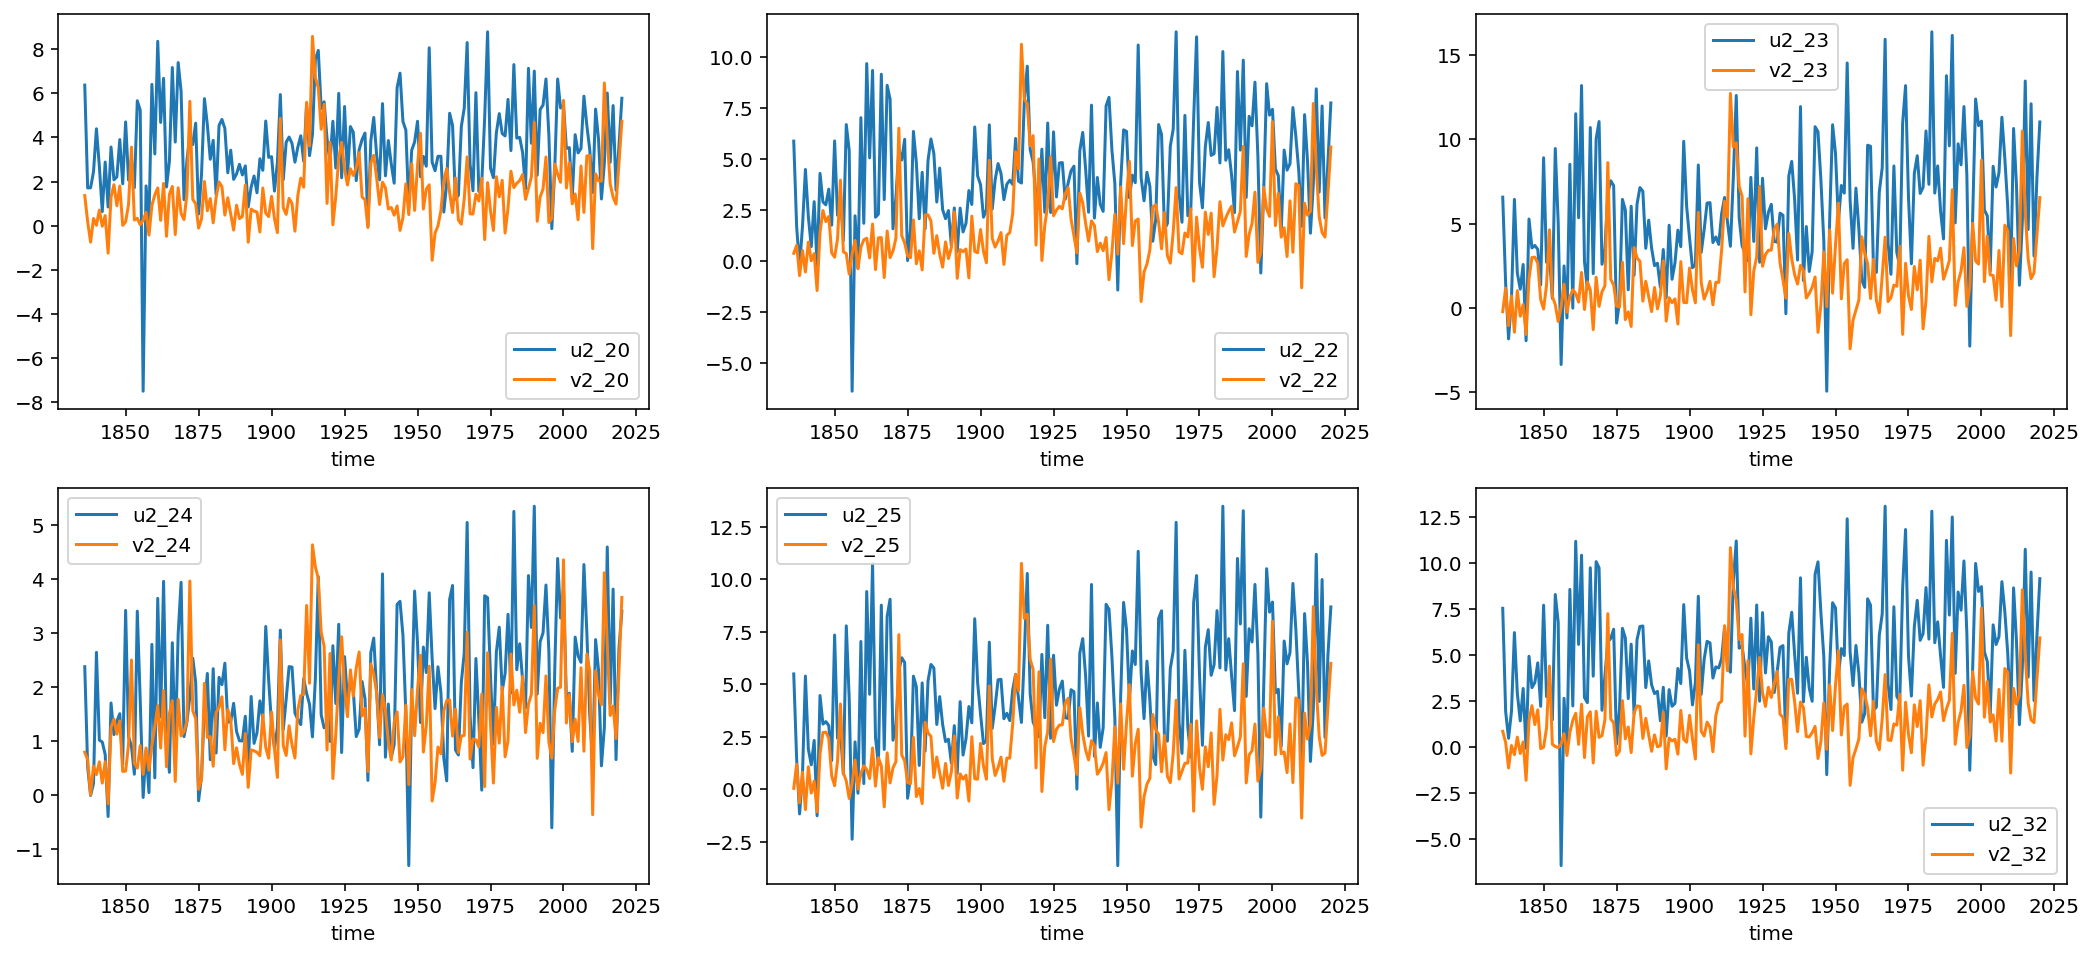

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,8))

for idx, tgi in enumerate(tg_id):
    nearest_point_df[[f'u2_{tgi}',f'v2_{tgi}']].plot(ax=axes[int(idx/3), idx%3])


In [13]:
argm = nearest_point_df['u2_20'].argmin()
nearest_point_df['u2_20'].index[argm]

1856

Is the year 1856 an outlier? Can we trust data for this year?

Cross-correlation between the zonal and meridional wind contributions

In [14]:
pearsonr(nearest_point_df['u2_mean'],nearest_point_df['v2_mean'])

(0.29727375467241673, 3.9696339908657984e-05)

The correlation between u2_mean and v2_mean would be almost impossible to obtain if those two time series were independent.

In [16]:
def normalize_ts(sr):
    
    sr = (sr-sr.mean())/sr.std()
    
    return sr

def read_pres_dangendorf(reanalysis):
    
    dang_pres = pd.read_csv(f'{path_data}IrisWind/wind_data/dangendorf_{reanalysis}_wind_data.csv')
    dang_pres.set_index('time', inplace=True)
    dang_pres.rename(columns={'Negative corr region' : 'pressure_north', 
                              'Positive corr region' : 'pressure_south'}, inplace=True)

    dang_pres['pressure_diff'] = dang_pres['pressure_south'] - dang_pres['pressure_north']
    
    # Normalize the values before linear regression
    dang_pres['pressure_north'] = normalize_ts(dang_pres['pressure_north'])
    dang_pres['pressure_south'] = normalize_ts(dang_pres['pressure_south'])
    dang_pres['pressure_diff'] = normalize_ts(dang_pres['pressure_diff'])    
    
    return dang_pres

dang_pres_20CR = read_pres_dangendorf('20cr')
dang_pres_ERA5 = read_pres_dangendorf('era5')

dang_df = combine_linear_scaling(dang_pres_20CR, dang_pres_ERA5, 1950, 2015)

dang_df

,pressure_north,pressure_south,pressure_diff
time,,,
1836,0.464363,-0.841373,-0.661936
1837,2.286081,-1.235890,-2.089893
1838,2.549557,-2.523874,-2.793357
1839,2.923375,-2.023197,-2.851564
1840,1.136720,-1.445493,-1.374071
...,...,...,...
2016,0.607819,0.766805,-0.156210
2017,-0.822726,1.451794,1.131480
2018,1.348870,-0.656429,-1.218069


### Define the relation between wind and sea level

There are different ways to remove the wind effect on sea level. We choose here the 'NearestPoint' method that picks for each tide gauge the closest grid point from the reanalysis data and applies a multi-linear regression model between the square of the zonal and meridioan wind components and sea level. See the master thesis of Iris Keizer or the [zeespiegel monitor 2018](https://www.deltares.nl/app/uploads/2019/03/Zeespiegelmonitor-2018-final.pdf) for more details about this method.

#### Prepare a matrix of potential regressors

In [18]:
t = tg_df.index

reg_df = pd.DataFrame({'sea_level':tg_df['Average']})

reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)

reg_df = reg_df.join(nearest_point_df, how='inner')
reg_df = reg_df.join(dang_df, how='inner')
reg_df = reg_df.join(timmerman_df, how='inner')
    
reg_df['one'] = np.ones(len(reg_df.index))

reg_df

,sea_level,nod1,nod2,u2_20,v2_20,u2_22,v2_22,u2_23,v2_23,u2_24,...,South_box_v,Mid_West_box_u,Mid_West_box_v,Mid_East_box_u,Mid_East_box_v,North_West_box_u,North_West_box_v,North_East_box_u,North_East_box_v,one
time,,,,,,,,,,,,,,,,,,,,,
1890,-12.464961,1.000000,0.000000,2.299926,0.420154,0.741532,0.651707,1.216533,0.731313,1.004132,...,2.278904,4.695434,5.051291,8.000561,1.446143,7.684370,8.537691,6.246377,4.642599,1.0
1891,-10.898294,0.943562,0.331195,2.711075,1.839982,2.591845,2.402508,3.465062,2.792695,1.461817,...,5.052596,5.161893,7.729379,6.418182,3.220227,6.485160,9.419870,3.807396,6.540657,1.0
1892,-9.648294,0.780620,0.625006,0.847894,-0.750894,0.441947,-0.858013,0.604136,-0.780719,0.532360,...,-0.487251,3.176605,2.015649,5.551543,0.475471,4.904046,3.625027,3.489497,2.221470,1.0
1893,-7.214961,0.529565,0.848270,1.746642,0.751908,2.583418,0.548177,4.905580,0.608318,1.827989,...,1.362358,7.243204,2.408348,9.426126,0.679750,7.805591,1.503756,5.494665,1.622161,1.0
1894,-7.181628,0.218735,0.975784,2.251795,0.655671,1.415255,0.450729,1.699421,0.313724,0.959504,...,1.238059,3.645708,2.392025,5.514304,0.753804,7.806068,4.778282,5.080973,1.538537,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,14.701706,0.121980,-0.992533,2.870051,1.896356,3.363882,2.166762,4.651974,2.891941,1.690045,...,4.498850,6.923596,5.184094,6.810984,3.427116,7.597813,6.267682,4.461437,4.732050,1.0
2017,18.218372,0.443818,-0.896117,5.444860,1.283815,7.589889,1.384334,12.107493,1.738461,3.815608,...,3.426914,14.169804,3.417031,14.964135,2.080100,14.097347,2.171513,10.129291,1.463370,1.0
2018,10.935039,0.715559,-0.698552,1.602423,0.977323,2.100778,1.163862,3.076881,2.088570,0.658923,...,4.187985,4.496034,6.309510,3.586638,4.432323,3.963554,9.809931,0.817733,7.038953,1.0


In [19]:
reg_df.filter(regex='v2_')

,v2_20,v2_22,v2_23,v2_24,v2_25,v2_32,v2_mean
time,,,,,,,
1890,0.420154,0.651707,0.731313,0.385161,0.828697,0.087541,0.517429
1891,1.839982,2.402508,2.792695,1.142278,2.536376,1.911005,2.104141
1892,-0.750894,-0.858013,-0.780719,0.145880,-0.423893,-1.170338,-0.639663
1893,0.751908,0.548177,0.608318,0.838268,0.726806,0.503168,0.662774
1894,0.655671,0.450729,0.313724,0.821668,0.482760,0.346874,0.511904
...,...,...,...,...,...,...,...
2016,1.896356,2.166762,2.891941,1.476623,2.518695,2.388227,2.223100
2017,1.283815,1.384334,1.738461,1.651636,1.608587,1.481745,1.524763
2018,0.977323,1.163862,2.088570,1.047926,1.724348,1.343773,1.390967


#### Define the list of regressors and regression formula for the different models

In [20]:
# No regressor

reg_list_nr = ['one']

regression_formula_nr = 'sea_level ~ '+' + '.join(reg_list_nr)

regression_formula_nr

'sea_level ~ one'

In [21]:
# Only lunar nodal tide

reg_list_nt = ['nod1', 'nod2']

regression_formula_nt = 'sea_level ~ '+' + '.join(reg_list_nt)

regression_formula_nt

'sea_level ~ nod1 + nod2'

In [22]:
# Nearest point

reg_list_np = ['nod1', 'nod2']

for tid in tg_id:
    reg_list_np.append(f'u2_{tid}')
    reg_list_np.append(f'v2_{tid}')

regression_formula_np = 'sea_level ~ '+' + '.join(reg_list_np)
    
regression_formula_np

'sea_level ~ nod1 + nod2 + u2_20 + v2_20 + u2_22 + v2_22 + u2_23 + v2_23 + u2_24 + v2_24 + u2_25 + v2_25 + u2_32 + v2_32'

In [23]:
# Timmerman

reg_list_ti = ['nod1', 'nod2']

for col in reg_df.filter(regex='_box_').columns:
    reg_list_ti.append(col)
    
regression_formula_ti = 'sea_level ~ '+' + '.join(reg_list_ti)
    
regression_formula_ti

'sea_level ~ nod1 + nod2 + Channel_box_u + Channel_box_v + South_box_u + South_box_v + Mid_West_box_u + Mid_West_box_v + Mid_East_box_u + Mid_East_box_v + North_West_box_u + North_West_box_v + North_East_box_u + North_East_box_v'

In [24]:
# Dangendorf

reg_list_da = ['nod1', 'nod2', 'pressure_north', 'pressure_south']

regression_formula_da = 'sea_level ~ '+' + '.join(reg_list_da)
    
regression_formula_da

'sea_level ~ nod1 + nod2 + pressure_north + pressure_south'

In [25]:
# Nearest point average

reg_list_na = ['nod1', 'nod2', 'u2_mean']

regression_formula_na = 'sea_level ~ '+' + '.join(reg_list_na)
    
regression_formula_na

'sea_level ~ nod1 + nod2 + u2_mean'

In [26]:
# Pressure difference

reg_list_pd = ['nod1', 'nod2', 'pressure_diff']

regression_formula_pd = 'sea_level ~ '+' + '.join(reg_list_pd)
    
regression_formula_pd

'sea_level ~ nod1 + nod2 + pressure_diff'

In [27]:
def reg_list_formula(model):
    if model == 'NoRegressor':
        reg_list = reg_list_nr
        regression_formula = regression_formula_nr
    elif model == 'NodalTide':
        reg_list = reg_list_nt
        regression_formula = regression_formula_nt  
    elif model == 'NearestPoint':
        reg_list = reg_list_np
        regression_formula = regression_formula_np
    elif model == 'Timmerman':
        reg_list = reg_list_ti
        regression_formula = regression_formula_ti
    elif model == 'Dangendorf':
        reg_list = reg_list_da
        regression_formula = regression_formula_da
    elif model == 'NearestPointAverage':
        reg_list = reg_list_na
        regression_formula = regression_formula_na
    elif model == 'PressureDifference':
        reg_list = reg_list_pd
        regression_formula = regression_formula_pd
        
    return reg_list, regression_formula

### Define generalised additive model and store data

In [28]:
if method == 'm1':
    gam_df = 5
    gam_alpha = 0
elif method == 'm2':
    gam_df = nt//2
    gam_alpha = 5000

In [29]:
def gam_model(reg_df, regression_formula, summary=False):

    bs_ts = BSplines(reg_df.index, df=gam_df, degree=3) 
    # alpha is the penalization weight for smooth terms
    gam_bs_ts = GLMGam.from_formula(regression_formula, data=reg_df, smoother=bs_ts, alpha=gam_alpha)
    res_gam = gam_bs_ts.fit()

    if summary:
        print(res_gam.summary())
        
    return res_gam

In [30]:
def store_results_df(reg_df, res_gam, reg_list, model):

    # Store model results in a dataframe
    model_results_df = pd.DataFrame(index=reg_df.index)

    for proc in reg_list: 
        model_results_df[proc] = reg_df[proc]*res_gam.params[proc]

    model_results_df['trend'] = res_gam.partial_values(0, True)[0]
    model_results_df['total'] = model_results_df.sum(axis=1)

    model_results_df['trend_se'] = res_gam.partial_values(0, True)[1]
    model_results_df['trend_se_squared'] = (model_results_df['trend_se'])**2

    if 'nod1' in res_gam.params.index:
        model_results_df['total_nodal'] = model_results_df['nod1'] + model_results_df['nod2']

    if model in ['NearestPoint', 'NearestPointAverage']:
        model_results_df['total_wind'] = model_results_df.filter(regex='[u-v]2_').sum(axis=1)
    elif model == 'Timmerman':
        model_results_df['total_wind'] = model_results_df.filter(regex='_box_').sum(axis=1)
    elif model == 'Dangendorf':
        model_results_df['total_wind'] = model_results_df.pressure_north + model_results_df.pressure_north
    elif model == 'PressureDifference':
        model_results_df['total_wind'] = model_results_df.pressure_diff

    return model_results_df

In [31]:
def compute_model(model, reg_df):
    
    reg_list, regression_formula = reg_list_formula(model)
    res_gam = gam_model(reg_df, regression_formula, summary=False)
    model_results_df = store_results_df(reg_df, res_gam, reg_list, model)
    
    return model_results_df, res_gam

### Computations for all models

In [32]:
res_nr, res_full_nr = compute_model('NoRegressor', reg_df)

In [33]:
res_nt, res_full_nt = compute_model('NodalTide', reg_df)

In [34]:
res_np, res_ful_np = compute_model('NearestPoint', reg_df)

In [35]:
res_ti, res_full_ti = compute_model('Timmerman', reg_df)

In [36]:
res_da, res_full_da = compute_model('Dangendorf', reg_df)

In [37]:
res_na, res_full_na = compute_model('NearestPointAverage', reg_df)

In [38]:
res_pd, res_full_pd = compute_model('PressureDifference', reg_df)

#### Look at the wind effect on sea level separately

In [39]:
model_list = ['NoRegressor', 'NodalTide', 'NearestPoint', 'Timmerman', 
              'Dangendorf', 'NearestPointAverage', 'PressureDifference']

In [40]:
for idx, res in enumerate([res_np, res_ti, res_da, res_na, res_pd]):
    
    if idx == 0:
        windcomp = pd.DataFrame({f'wind_{model_list[2+idx]}' : res.total_wind})
    else:
        windcomp[f'wind_{model_list[2+idx]}'] = res.total_wind

    windcomp[f'wind_{model_list[2+idx]}'] = windcomp[f'wind_{model_list[2+idx]}'] - windcomp[f'wind_{model_list[2+idx]}'].mean()
        
    window = 31
    lowess = sm.nonparametric.lowess
    frac = window/windcomp.shape[0]
    
    windcomp[f'wind_{model_list[2+idx]}_trend'] = lowess(windcomp[f'wind_{model_list[2+idx]}'], 
                                                         windcomp.index, frac, return_sorted=False)

    windcomp[f'wind_{model_list[2+idx]}_trend_dt'] = detrend(windcomp[f'wind_{model_list[2+idx]}_trend'])

windcomp

,wind_NearestPoint,wind_NearestPoint_trend,wind_NearestPoint_trend_dt,wind_Timmerman,wind_Timmerman_trend,wind_Timmerman_trend_dt,wind_Dangendorf,wind_Dangendorf_trend,wind_Dangendorf_trend_dt,wind_NearestPointAverage,wind_NearestPointAverage_trend,wind_NearestPointAverage_trend_dt,wind_PressureDifference,wind_PressureDifference_trend,wind_PressureDifference_trend_dt
time,,,,,,,,,,,,,,,
1890,-2.116535,-1.868507,-0.601506,-1.317433,-1.580845,-0.540571,-0.478997,-1.865973,-0.731608,-3.051147,-2.394899,-1.128822,-0.838680,-1.557601,-0.450693
1891,-1.219436,-1.806620,-0.558758,-0.821204,-1.500859,-0.478133,-1.925561,-1.849217,-0.733762,-1.732300,-2.278759,-1.030889,-0.820029,-1.509715,-0.420717
1892,-3.471015,-1.744294,-0.515570,-2.681496,-1.420486,-0.415307,-2.035125,-1.830779,-0.734233,-3.690678,-2.164474,-0.934811,-2.273010,-1.460949,-0.389860
1893,0.365401,-1.681380,-0.471794,-0.268642,-1.339823,-0.352191,-0.200176,-1.810806,-0.733170,-1.447460,-2.052087,-0.840631,-1.341458,-1.411533,-0.358353
1894,-2.150837,-1.617551,-0.427103,-1.542457,-1.258847,-0.288763,-2.229344,-1.789470,-0.730744,-2.707154,-1.941453,-0.748204,-0.947115,-1.361630,-0.326359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,-0.641329,0.573238,-0.571206,-0.117718,1.240800,0.070112,-1.755983,1.063504,-0.184765,-1.109164,0.443498,-0.584514,0.134970,1.037356,-0.112305
2017,2.450096,0.563030,-0.600552,4.065285,1.270281,0.082046,3.409959,1.113767,-0.153412,3.183269,0.440862,-0.605357,2.712130,1.065680,-0.101890
2018,-2.963481,0.555237,-0.627484,-3.032086,1.302001,0.096218,-4.432040,1.167165,-0.118924,-2.359529,0.440076,-0.624350,-1.990214,1.095924,-0.089555


Text(0, 0.5, 'Sea level change [cm]')

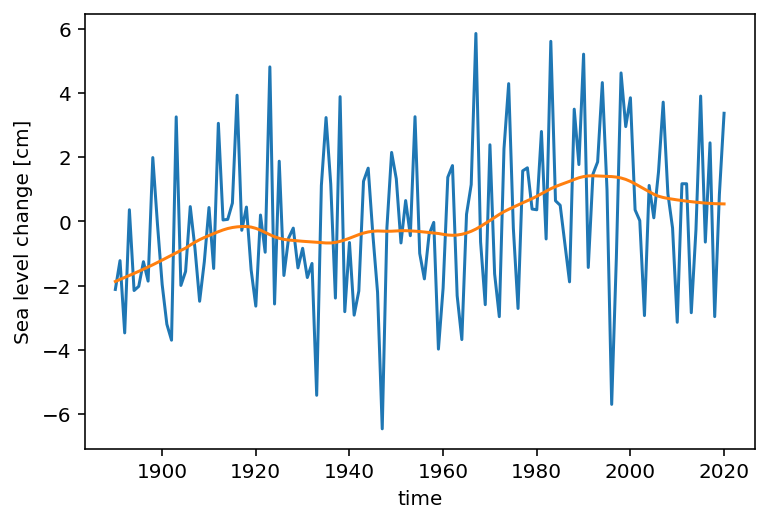

In [41]:
windcomp[['wind_NearestPoint', 'wind_NearestPoint_trend']].plot(legend=False)

plt.ylabel('Sea level change [cm]')

#plt.savefig(f'NearestPointWindInfluenceSL.pdf', dpi=150)

(-1.3, 1.8)

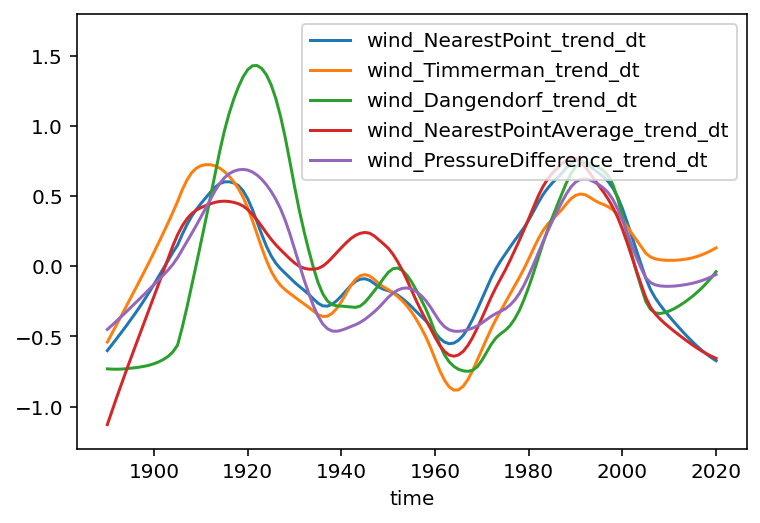

In [42]:
windcomp.filter(regex='_trend_dt').plot()
plt.ylim([-1.3, 1.8])

#### Compute the rate of sea level rise

First time this cell is run
First time this cell is run
First time this cell is run
First time this cell is run
First time this cell is run
First time this cell is run
First time this cell is run


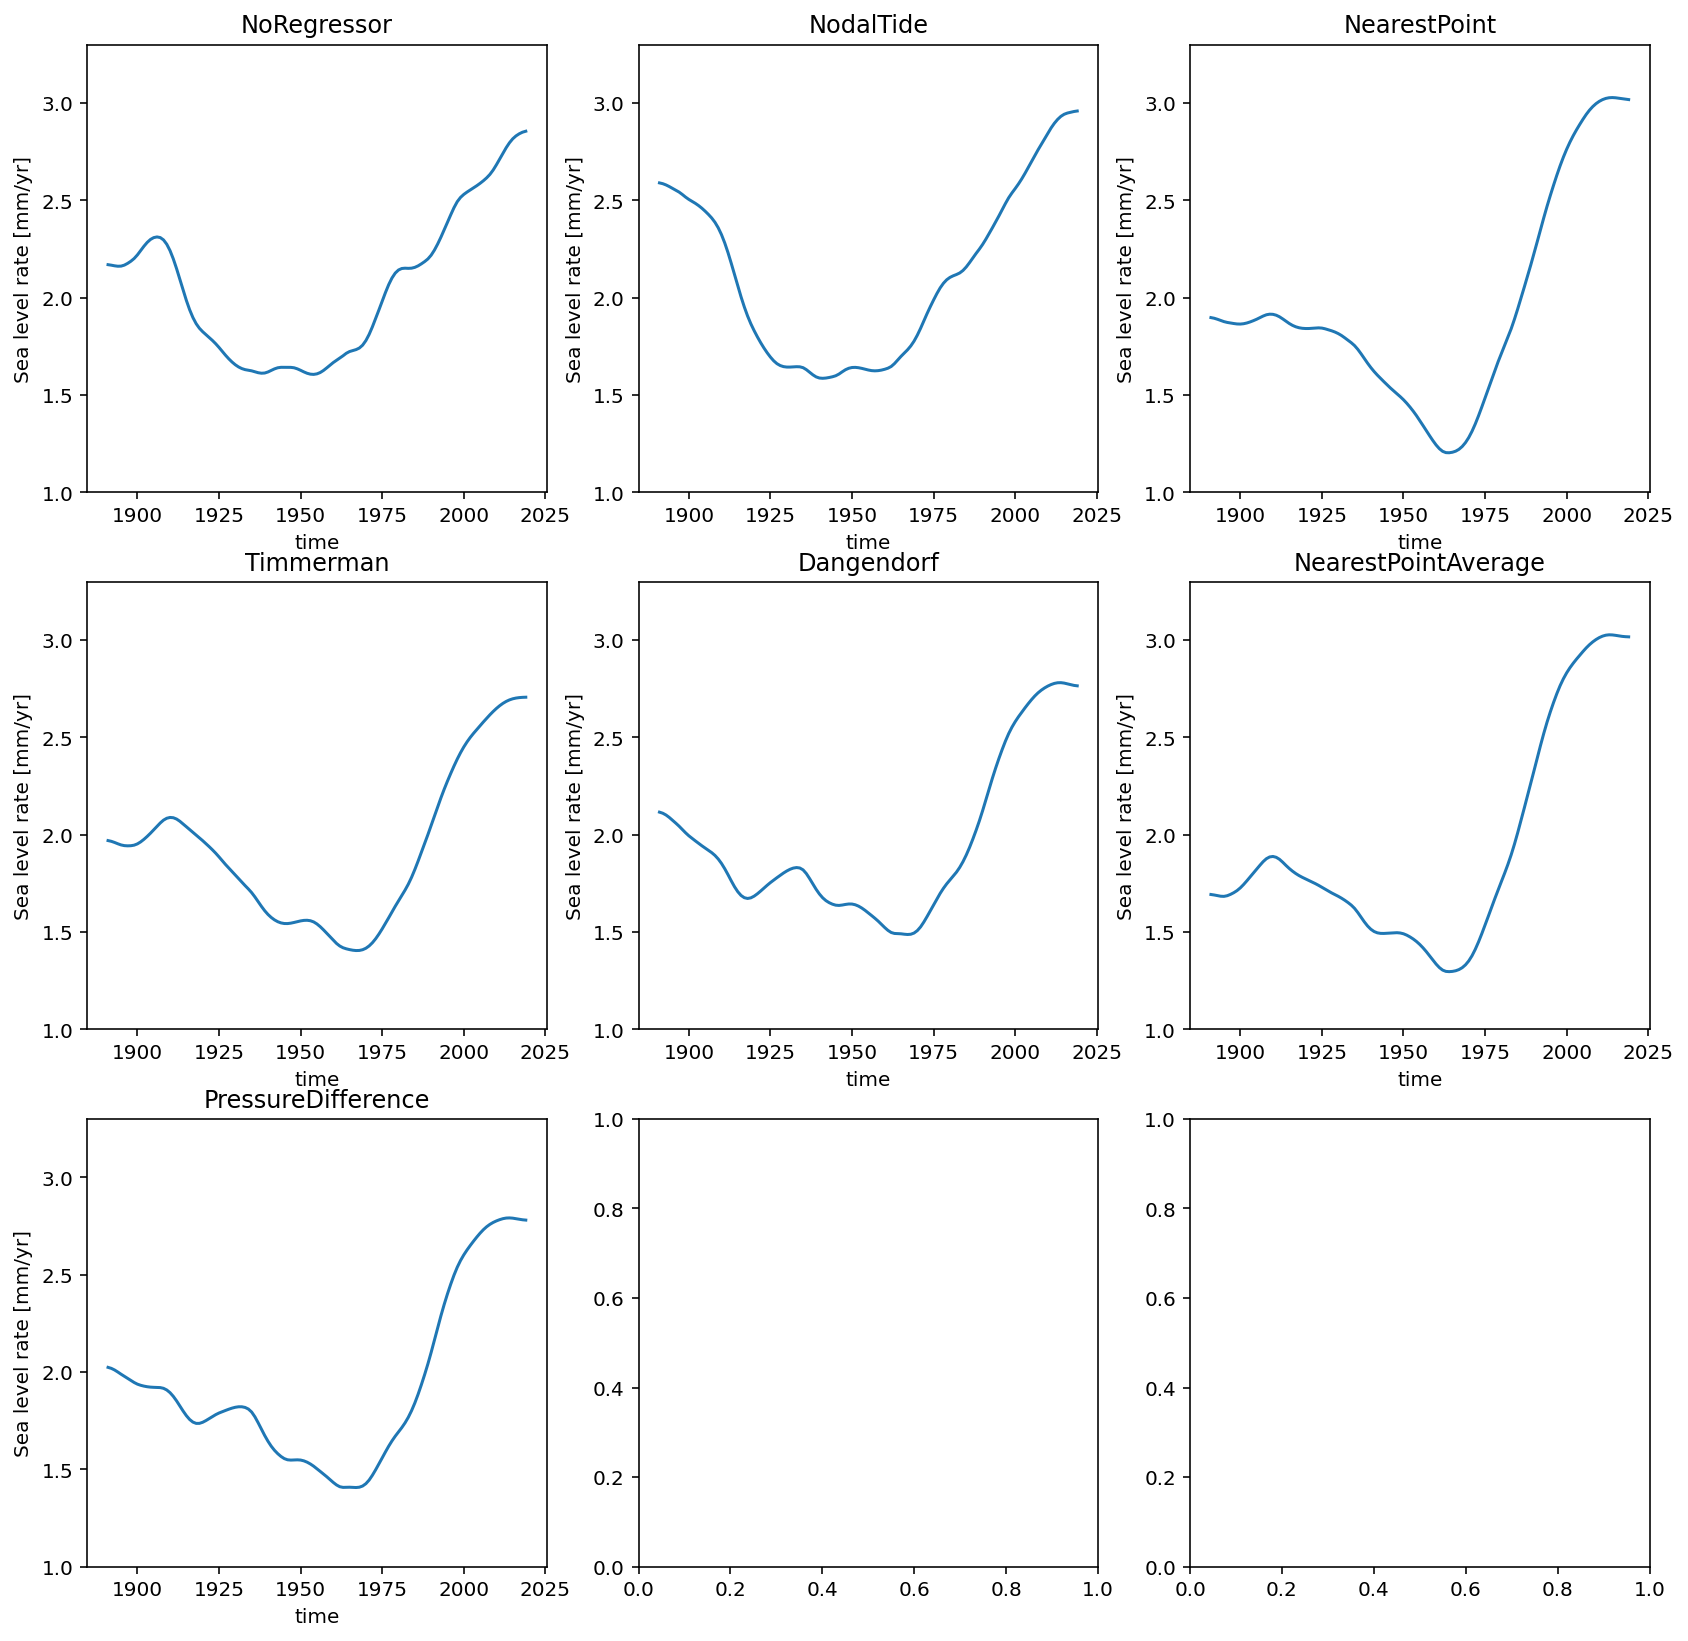

In [43]:
fig, ax = plt.subplots(3, 3, figsize=(14,14))

for idx,res in enumerate([res_nr, res_nt, res_np, res_ti, res_da, res_na, res_pd]):

    try:
        del(res['rate_slr'])
    except:
        print('First time this cell is run')
    
    res['rate_slr'] = res.trend.diff(lag).shift(-int(lag/2))/lag
    sum_var = (np.array(res.trend_se_squared.iloc[int(lag):]) + 
               np.array(res.trend_se_squared.iloc[:-int(lag)]) )
    
    # Convert from cm/yr to mm/yr
    res['rate_slr'] = res['rate_slr']*10

    res.rate_slr.plot(ax=ax.flat[idx], title=model_list[idx])
    
    ax.flat[idx].set_ylabel('Sea level rate [mm/yr]')
    ax.flat[idx].set_ylim([1, 3.3])

#plt.savefig(f'./figures/sealevel_rate_all_models_alpha20000.pdf', dpi=150)

Export model data to csv files

In [44]:
# for idx, df in enumerate([res_nr, res_nt, res_np, res_ti, res_da, res_na, res_pd]):
#     df.to_csv(f'./outputs/Results_{model_list[idx]}.csv')

#### Compare the standard error in the trend from all methods using the statsmodel computation which is different from that used in the paper defined below.

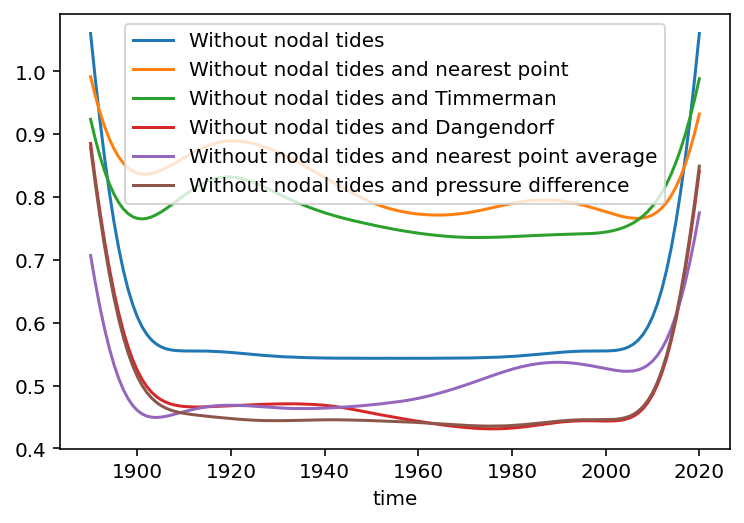

In [45]:
#res_nr.trend_se.plot(label='Original data')
res_nt.trend_se.plot(label='Without nodal tides')
res_np.trend_se.plot(label='Without nodal tides and nearest point')
res_ti.trend_se.plot(label='Without nodal tides and Timmerman')
res_da.trend_se.plot(label='Without nodal tides and Dangendorf')
res_na.trend_se.plot(label='Without nodal tides and nearest point average')
res_pd.trend_se.plot(label='Without nodal tides and pressure difference')

plt.legend()

This shows the importance of using less predictive variables for the wind in order to reduce the standard error in the trend.

### Compute the uncertainty in the rate of sea level rise

We use here a parametric bootstrap method

In [329]:
def mtm(y, dt, NW=2.5, k=4):
    '''Use multi-taper method from the Spectrum library
    NW is he time half bandwidth parameter
    k the number of Slepian sequences to use.
    Additional information on how to use the library:
    https://stackoverflow.com/questions/62836233/multi-taper-spectral-analysis-with-spectrum-in-python'''
    
    N = len(y)
    xf = np.linspace(0.0, 1.0/(2.0*dt), N//2)
    
    # The multitapered method
    [tapers, eigen] = sp.dpss(N, NW, k)
    Sk_complex, weights, eigenvalues=sp.pmtm(y, e=eigen, v=tapers, NFFT=N, show=False)

    Sk = abs(Sk_complex)**2
    Sk = np.mean(Sk * np.transpose(weights), axis=0) * dt
    
    yf_full = Sk
    yf = Sk[0:N//2]
    
    return xf, yf, yf_full

def generate_residual(nt, ssp):
    '''Generate another possible residual from an amplitude spectrum'''
    
    N = np.random.normal(0, 1, nt)
    z = fft.fft(N)*ssp
    new_res = fft.ifft(z).real # realisation of residual (independent signals)
    
    return new_res

def adjust_psd(sp, residuals, reg_df, regression_formula, bootsize):
    '''Adjust the power spectrum density of the residual by taking into account 
    the power reduction of fitting the model'''
    
    ssp_adj = sp
    
    for it in range(5):
        ssp = np.sqrt(ssp_adj) # Compute the amplitude spectrum from the power spectrum
        splain = np.zeros(nt)
        sfitted = np.zeros(nt)

        for i in range(bootsize):

            v = generate_residual(nt, ssp)

            # Replace residual in sea level data
            reg_df['new_sea_level'] = reg_df['sea_level'] - residuals + v

            # Estimate model
            res_gam = gam_model(reg_df, regression_formula, summary=False)

            residual1 = res_gam.resid_response.values

            splain = splain + mtm(v, 1, NW=10, k=20)[2]
            sfitted = sfitted + mtm(residual1, 1, NW=10, k=20)[2]

        splain = splain/bootsize
        sfitted = sfitted/bootsize
        ssp_adj = sp*(splain/sfitted)
    
    return splain, sfitted, ssp_adj

def bootstrap_trend(ssp_adj, residuals, reg_df, regression_formula, bootsize):
    '''Compute multiple possible trend estimates using a parametric bootstrap 
    method taking the adjusted spectrum of residuals as input'''
    
    ssp = np.sqrt(ssp_adj)
    trend_matrix = np.zeros([nt, bootsize])

    for i in range(bootsize):

        v = generate_residual(nt, ssp)
        
        # Replace residual in sea level data
        reg_df['new_sea_level'] = reg_df['sea_level'] - residuals + v

        # Estimate model
        res_gam = gam_model(reg_df, regression_formula, summary=False)
        trend_matrix[:, i] = res_gam.partial_values(0, True)[0]
    
    trend_df = pd.DataFrame(data=trend_matrix, index=reg_df.index)

    return trend_df

def compute_rate(trend, lag):
    'Compute the rate of sea level rise in mm/yr'
    
    rate = trend.diff(lag).shift(-int(lag/2))/lag
    rate = rate*10 # Convert from cm/year to mm/year
    
    return rate

def rates_quantiles(trend_df, lag, quantiles):
    '''Compute the rates by finite difference using a lag in years and a 
    few quantiles'''
    
    rates = compute_rate(trend_df, lag)
    
    for idx, q in enumerate(quantiles):
        if idx == 0:
            rates_q = pd.DataFrame({q:rates.std(axis=1)*norm.ppf(q)})
        else:
            rates_q[q] = rates.std(axis=1)*norm.ppf(q)

    return rates, rates_q

def rate_uncertainty(model, reg_df, bootsize):
    '''Combines the functions above to output the rate and a few quantiles'''
    
    lag = 2 # Lag in years for the computation of the rate from the trend
    quant = [0.05, 0.17, 0.50, 0.83, 0.95] # Quantiles to return

    res, res_full = compute_model(model, reg_df)
    rate = compute_rate(res.trend, lag)
    
    residuals = res_full.resid_response.values
    
    xf_mtm, yf_mtm, yf_full_mtm = mtm(residuals, 1, NW=10, k=20)
    
    reg_list, regression_formula = reg_list_formula(model)
    new_regression_formula = regression_formula.replace('sea_level','new_sea_level')

    splain, sfitted, ssp_adj = adjust_psd(yf_full_mtm, residuals, reg_df, new_regression_formula, bootsize)
    
    # Store spectra data
    spec_df = pd.DataFrame({'splain':splain[0:nt//2], 'sfitted':sfitted[0:nt//2], 
                            'residual':yf_full_mtm[0:nt//2], 'noise':ssp_adj[0:nt//2]}, 
                           index = xf_mtm)
    
    trend_df = bootstrap_trend(ssp_adj, residuals, reg_df, new_regression_formula, bootsize)
    
    rates, rates_q = rates_quantiles(trend_df, lag, quant)
    
    for q in quant:
        rates_q[q] = rate + rates_q[q]
        
    for i in range(bootsize):
        rates[i] = rate + rates[i]
    
    return trend_df, rates, rates_q, spec_df

#### Showcase the method for the nearest point average model

In [330]:
# Extract the residuals
# Equivalent to (reg_df.sea_level - res_na.total)

bootsize = 100             # sample size of (parametric) bootstrap

residuals = res_full_na.resid_response.values #res_full_nr, res_full_na


In [331]:
xf_mtm, yf_mtm, yf_full_mtm = mtm(residuals, 1, NW=10, k=20)
xf_mtm_r, yf_mtm_r, yf_full_mtm_r = mtm(residuals, 1)

Text(0.5, 0, 'Frequency [cycle/year]')

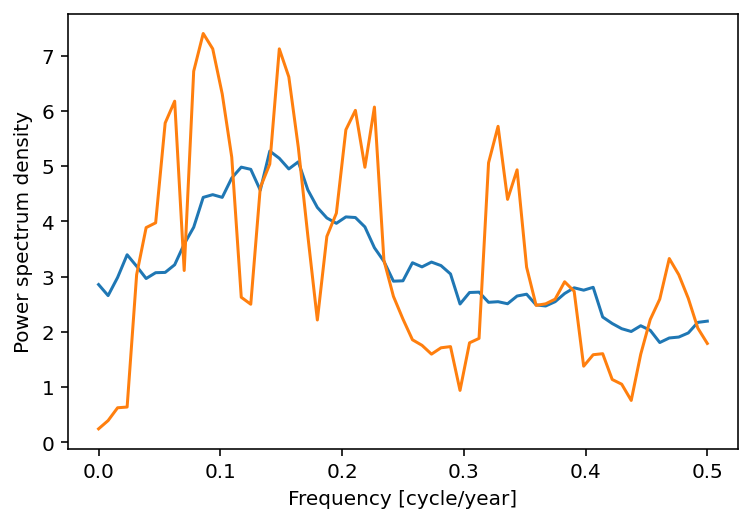

In [332]:
plt.plot(xf_mtm, yf_mtm, xf_mtm_r, yf_mtm_r)
plt.ylabel('Power spectrum density')
plt.xlabel('Frequency [cycle/year]')


In [333]:
reg_list, regression_formula = reg_list_formula('NearestPointAverage') #, 'NoRegressor', 'NearestPointAverage'
new_regression_formula = regression_formula.replace('sea_level','new_sea_level')

splain, sfitted, ssp_adj = adjust_psd(yf_full_mtm, residuals, reg_df, new_regression_formula, bootsize)


In [334]:
splain2, sfitted2, ssp_adj2 = adjust_psd(ssp_adj, residuals, reg_df, new_regression_formula, bootsize)

In [335]:
splain3, sfitted3, ssp_adj3 = adjust_psd(ssp_adj2, residuals, reg_df, new_regression_formula, bootsize)

In [336]:
splain4, sfitted4, ssp_adj4 = adjust_psd(ssp_adj3, residuals, reg_df, new_regression_formula, bootsize)

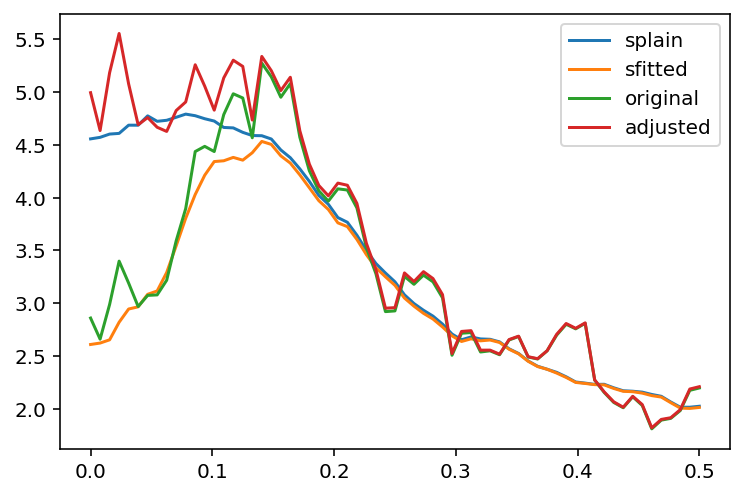

In [337]:
plt.plot(xf_mtm, splain[0:nt//2], label='splain')
plt.plot(xf_mtm, sfitted[0:nt//2], label='sfitted')
plt.plot(xf_mtm, yf_full_mtm[0:nt//2], label='original')
plt.plot(xf_mtm, ssp_adj[0:nt//2], label='adjusted')

plt.legend()

#plt.savefig('./figures/IncreasedNoise.pdf', dpi=150)

In [338]:
trend_df = bootstrap_trend(ssp_adj, residuals, reg_df, new_regression_formula, bootsize)

In [339]:
quant = [0.05, 0.17, 0.50, 0.83, 0.95]

rates, rates_q = rates_quantiles(trend_df, 2, quant)

for q in quant:
    rates_q[q] = res_na['rate_slr']+rates_q[q]

In [340]:
rates_q

,0.05,0.17,0.50,0.83,0.95
time,,,,,
1890,NaN,NaN,NaN,NaN,NaN
1891,1.021078,1.303271,1.693111,2.082952,2.365144
1892,1.019178,1.301114,1.690601,2.080087,2.362024
1893,1.017317,1.298588,1.687156,2.075724,2.356995
1894,1.017346,1.297357,1.684184,2.071011,2.351022
...,...,...,...,...,...
2016,2.343707,2.628409,3.021716,3.415023,3.699725
2017,2.336464,2.623175,3.019257,3.415339,3.702049
2018,2.331807,2.619813,3.017686,3.415559,3.703565


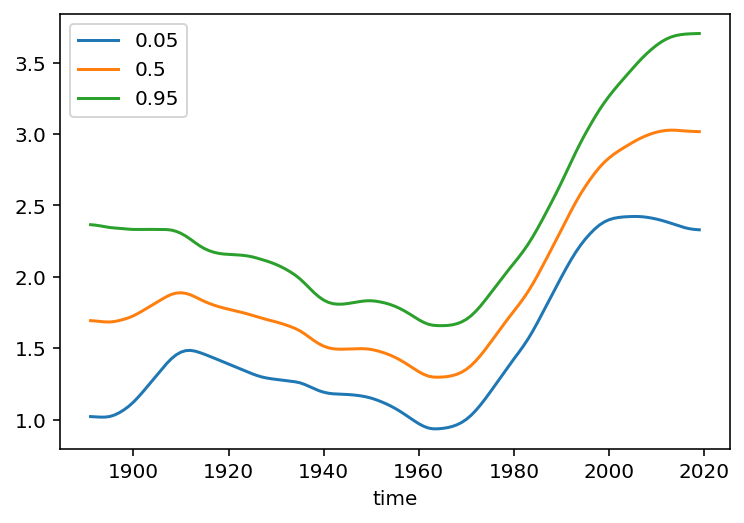

In [341]:
rates_q[[0.05,0.5,0.95]].plot()

#plt.savefig('./figures/rate_na_lag2.pdf', dpi=150)
plt.legend()

#### Check the convergence of adjust_psd

In [342]:
def adjust_psd2(sp, residuals, reg_df, regression_formula, bootsize):
    '''Adjust the power spectrum density of the residual by taking into account 
    the power reduction of fitting the model'''
    
    ssp_adj = sp
    
    for it in range(10):
        ssp = np.sqrt(ssp_adj) # Compute the amplitude spectrum from the power spectrum
        splain = np.zeros(nt)
        sfitted = np.zeros(nt)

        for i in range(bootsize):

            v = generate_residual(nt, ssp)

            # Replace residual in sea level data
            reg_df['new_sea_level'] = reg_df['sea_level'] - residuals + v

            # Estimate model
            res_gam = gam_model(reg_df, regression_formula, summary=False)

            residual1 = res_gam.resid_response.values

            splain = splain + mtm(v, 1, NW=10, k=20)[2]
            sfitted = sfitted + mtm(residual1, 1, NW=10, k=20)[2]

        splain = splain/bootsize
        sfitted = sfitted/bootsize
        ssp_adj = sp*(splain/sfitted)
        
        plt.plot(xf_mtm, splain[0:nt//2], label=f'iteration {it}')
        plt.legend()
    
    return splain, sfitted, ssp_adj

KeyboardInterrupt: 

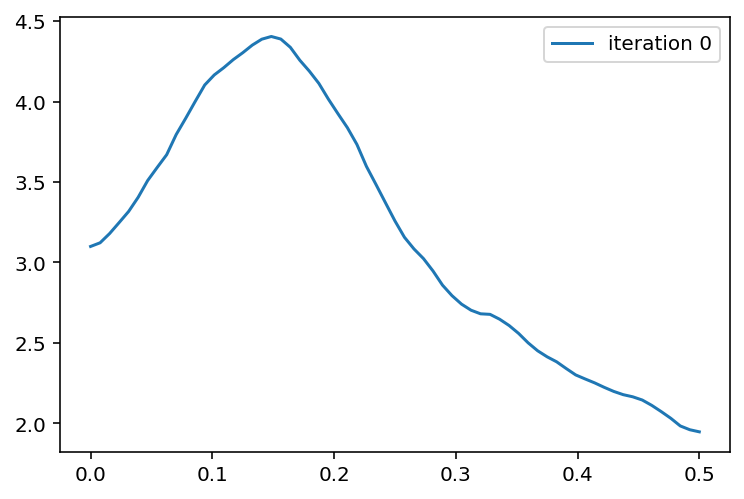

In [343]:
splain, sfitted, ssp_adj = adjust_psd2(yf_full_mtm, residuals, reg_df, new_regression_formula, bootsize=1000)

Three iterations seem to be enough for convergence

#### Compute the rates for all methods

In [ ]:
long_names = ['Trend only', 
              'Trend and nodal tide', 
              'Trend, nodal tide and wind (velocity)', 
              'Trend, nodal tide and wind (pressure)']

short_names = ['Tr', 'TrNc', 'TrNcZw', 'TrNcPd']

comb_names = [f'{short_names[i]} : {long_names[i]}' for i in range(4)]

In [235]:
bootsize = 1000

trend_nr, rates_nr, rates_q_nr, spec_nr = rate_uncertainty('NoRegressor', reg_df, bootsize)
trend_nt, rates_nt, rates_q_nt, spec_nt = rate_uncertainty('NodalTide', reg_df, bootsize)
trend_na, rates_na, rates_q_na, spec_na = rate_uncertainty('NearestPointAverage', reg_df, bootsize)
trend_pd, rates_pd, rates_q_pd, spec_pd = rate_uncertainty('PressureDifference', reg_df, bootsize)

#### Store data as csv files

In [ ]:
# for idx, df in enumerate([res_nr, res_nt, res_np, res_ti, res_da, res_na, res_pd]):
#     df.to_csv(f'./outputs/Results_{model_list[idx]}.csv')

In [275]:
res_nr

,one,trend,total,trend_se,trend_se_squared,rate_slr
time,,,,,,
1890,-5.465823,-5.464168,-10.929991,1.115914e+06,1.245265e+12,NaN
1891,-5.465823,-5.247192,-10.713015,1.115914e+06,1.245265e+12,2.168899
1892,-5.465823,-5.030388,-10.496211,1.115914e+06,1.245265e+12,2.166317
1893,-5.465823,-4.813928,-10.279752,1.115914e+06,1.245265e+12,2.163114
1894,-5.465823,-4.597765,-10.063589,1.115914e+06,1.245265e+12,2.160919
...,...,...,...,...,...,...
2016,-5.465823,20.113442,14.647618,1.115914e+06,1.245265e+12,2.830493
2017,-5.465823,20.397108,14.931285,1.115914e+06,1.245265e+12,2.841437
2018,-5.465823,20.681729,15.215906,1.115914e+06,1.245265e+12,2.849596


In [276]:
test_df = rates_q_nr.copy()
test_df['se'] = rates_q_nr[0.95]
test_df

,0.05,0.17,0.5,0.83,0.95,se
time,,,,,,
1890,NaN,NaN,NaN,NaN,NaN,NaN
1891,0.993479,1.487048,2.168899,2.850751,3.344320,3.344320
1892,0.993677,1.486079,2.166317,2.846554,3.338956,3.338956
1893,0.996153,1.486171,2.163114,2.840058,3.330075,3.330075
1894,1.003227,1.489352,2.160919,2.832486,3.318611,3.318611
...,...,...,...,...,...,...
2016,1.700171,2.174803,2.830493,3.486183,3.960815,3.960815
2017,1.702984,2.181031,2.841437,3.501844,3.979890,3.979890
2018,1.706351,2.186410,2.849596,3.512783,3.992842,3.992842


#### Compare standard error in trends and rates

In [236]:
# Compute the standard errors in trends

set_nr = trend_nr.std(axis=1)
set_nt = trend_nt.std(axis=1)
set_na = trend_na.std(axis=1)
set_pd = trend_pd.std(axis=1)


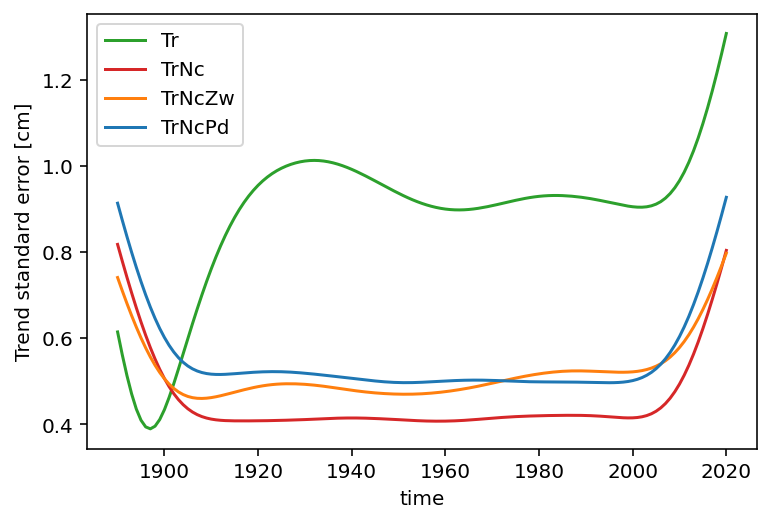

In [237]:
colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:blue']

set_nr.plot(color = colors[0], label=short_names[0])
set_nt.plot(color = colors[1], label=short_names[1])
set_na.plot(color = colors[2], label=short_names[2])
set_pd.plot(color = colors[3], label=short_names[3])

plt.ylabel('Trend standard error [cm]')
plt.legend()

In [238]:
# Compute the standard errors in rates

ser_nr = rates_nr.std(axis=1)
ser_nt = rates_nt.std(axis=1)
ser_na = rates_na.std(axis=1)
ser_pd = rates_pd.std(axis=1)


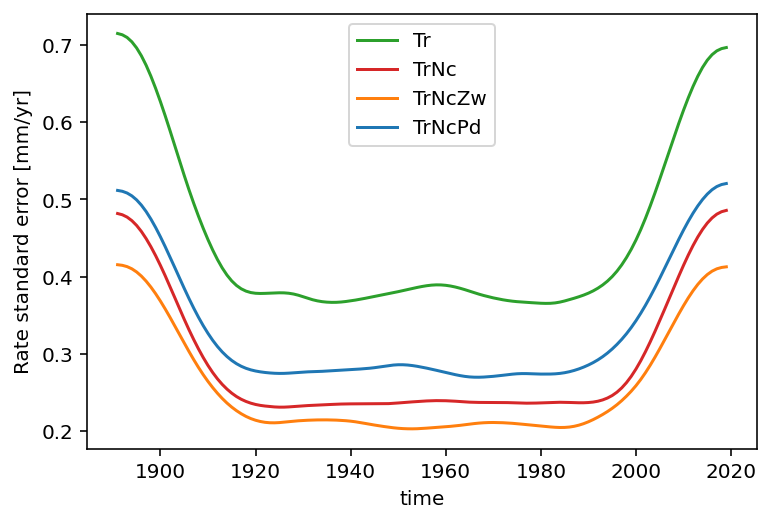

In [239]:
colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:blue']

ser_nr.plot(color = colors[0], label=short_names[0])
ser_nt.plot(color = colors[1], label=short_names[1])
ser_na.plot(color = colors[2], label=short_names[2])
ser_pd.plot(color = colors[3], label=short_names[3])

plt.ylabel('Rate standard error [mm/yr]')
plt.legend()


#### Compare power spectrum adjustment for the 4 methods

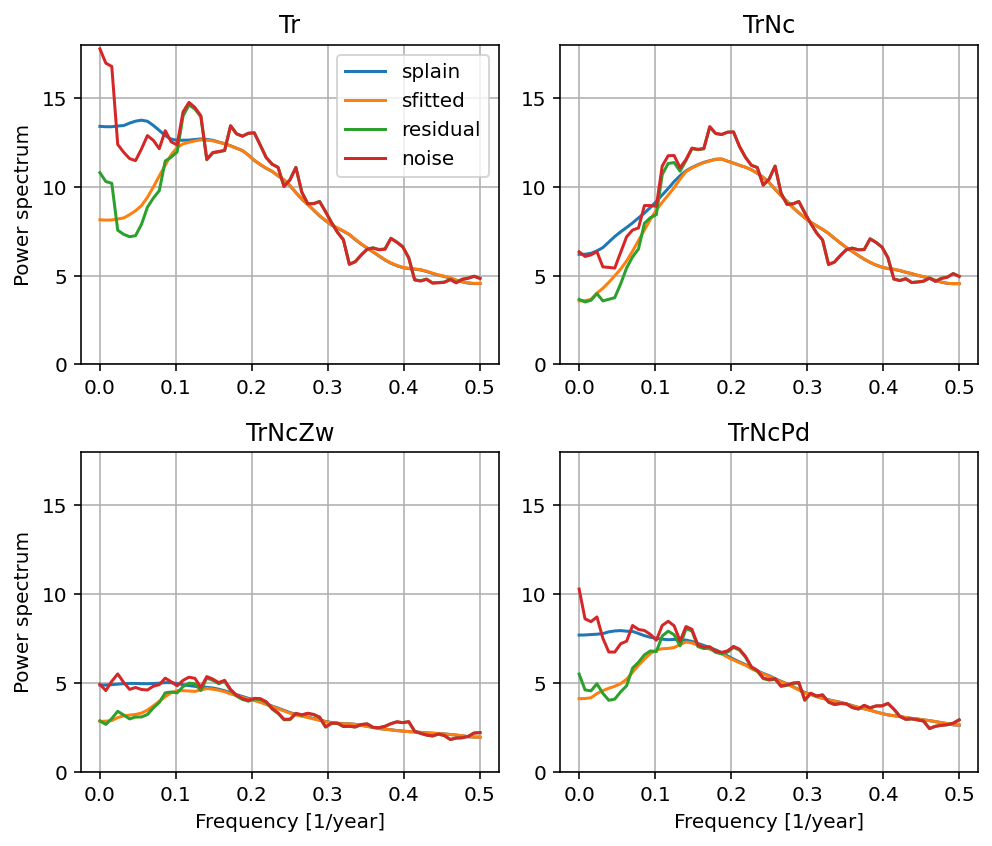

In [240]:
fig, ax = plt.subplots(2, 2, figsize=(7,6))

spec_nr.plot(ax=ax[0,0], title=short_names[0])
spec_nt.plot(ax=ax[0,1], title=short_names[1], legend=False)
spec_na.plot(ax=ax[1,0], title=short_names[2], legend=False)
spec_pd.plot(ax=ax[1,1], title=short_names[3], legend=False)

ax[1,0].set_xlabel('Frequency [1/year]')
ax[1,1].set_xlabel('Frequency [1/year]')

ax[0,0].set_ylabel('Power spectrum')
ax[1,0].set_ylabel('Power spectrum')

for idx in range(4):
    ax.flat[idx].set_ylim([0, 18])
    ax.flat[idx].grid(True)

fig.tight_layout()

#### Summary table of model performance

In [291]:
res_ar = np.zeros([4, 2])

for idd, df in enumerate([res_full_nr, res_full_nt, res_full_na, res_full_pd]):

    res_ar[idd, 0] = round(df.df_model,1)
    res_ar[idd, 1] = round(df.deviance,0)
        
resm_df = pd.DataFrame(res_ar, 
                      index=comb_names, 
                      columns=['Degrees of freedom', 'Deviance'])

resm_df.index.name = 'Statistical model'

In [292]:
resm_df

,Degrees of freedom,Deviance
Statistical model,,
Tr : Trend only,4.6,1167.0
TrNc : Trend and nodal tide,6.6,1031.0
"TrNcZw : Trend, nodal tide and wind (velocity)",7.6,428.0
"TrNcPd : Trend, nodal tide and wind (pressure)",7.6,652.0


Export to latex table format to copy paste directly to the paper

In [293]:
print(resm_df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Degrees of freedom &  Deviance \\
Statistical model                              &                     &           \\
\midrule
Tr : Trend only                                &                 4.6 &    1167.0 \\
TrNc : Trend and nodal tide                    &                 6.6 &    1031.0 \\
TrNcZw : Trend, nodal tide and wind (velocity) &                 7.6 &     428.0 \\
TrNcPd : Trend, nodal tide and wind (pressure) &                 7.6 &     652.0 \\
\bottomrule
\end{tabular}



#### Compute the p-values for the hypothesis that the rates are the same at different years

In [244]:
t1 = 2019
all_t0 = [1900, 1960]

list_rates = [rates_nr, rates_nt, rates_na, rates_pd]
list_rates_q = [rates_q_nr, rates_q_nt, rates_q_na, rates_q_pd]

col_names = [f'p-values [r({t1}) , r({y})]' for y in all_t0]

res_ar = np.zeros([4, 2])

for idt, t0 in enumerate(all_t0):
    for idd, (rates, rates_q) in enumerate(zip(list_rates, list_rates_q)):

        sigma = np.std(rates.loc[t1] - rates.loc[t0])

        # observed difference in rate
        drate = rates_q[0.5].loc[t1] - rates_q[0.5].loc[t0]

        # p-value is the probability that the estimated rate difference would exceed  
        # the value drate if the true rates were equal
        # (this looks like your formula!)
        res_ar[idd, idt] = round(1-norm.cdf(drate/sigma), 2)
    
res_df = pd.DataFrame(res_ar, 
                      index=short_names, 
                      columns=col_names)

res_df.index.name = 'Statistical model'

In [245]:
res_df

,"p-values [r(2019) , r(1900)]","p-values [r(2019) , r(1960)]"
Statistical model,,
Tr,0.26,0.08
TrNc,0.23,0.01
TrNcZw,0.01,0.00
TrNcPd,0.12,0.02


#### Compute the p-values for the hypothesis that the rates are the same at different periods

In [358]:
t1 = 2000
all_t0 = [1900, 1920, 1940]

list_rates = [rates_nr, rates_nt, rates_na, rates_pd]
list_rates_q = [rates_q_nr, rates_q_nt, rates_q_na, rates_q_pd]

col_names = [f'r_{{{t1}-{t1+19}}} vs r_{{{y}-{y+19}}}' for y in all_t0]

res_ar = np.zeros([4, 3])

for idt, t0 in enumerate(all_t0):
    for idd, (rates, rates_q) in enumerate(zip(list_rates, list_rates_q)):
        sigma = np.std(rates.loc[t1: t1+19].mean(axis=0) - 
                       rates.loc[t0: t0+19].mean(axis=0))

        # observed difference in rate
        drate = (rates_q[0.5].loc[t1: t1+19].mean(axis=0) - 
                 rates_q[0.5].loc[t0: t0+19].mean(axis=0))

        # p-value is the probability that the estimated rate difference would exceed  
        # the value drate if the true rates were equal
        # (this looks like your formula!)
        res_ar[idd, idt] = round(1-norm.cdf(drate/sigma), 2)
    
res_df = pd.DataFrame(res_ar, 
                      index=short_names, 
                      columns=col_names)

res_df.index.name = 'Statistical model'

In [359]:
res_df

,r_{2000-2019} vs r_{1900-1919},r_{2000-2019} vs r_{1920-1939},r_{2000-2019} vs r_{1940-1959}
Statistical model,,,
Tr,0.24,0.06,0.07
TrNc,0.12,0.00,0.00
TrNcZw,0.00,0.00,0.00
TrNcPd,0.05,0.03,0.01


In [193]:
print(res_df.to_latex(escape = False))

\begin{tabular}{lrrr}
\toprule
{} &  r_{2000-2019} vs r_{1900-1919} &  r_{2000-2019} vs r_{1920-1939} &  r_{2000-2019} vs r_{1940-1959} \\
Statistical model &                                 &                                 &                                 \\
\midrule
Tr                &                            0.23 &                            0.06 &                            0.05 \\
TrNc              &                            0.14 &                            0.01 &                            0.01 \\
TrNcZw            &                            0.00 &                            0.00 &                            0.00 \\
TrNcPd            &                            0.05 &                            0.02 &                            0.01 \\
\bottomrule
\end{tabular}



In the paper replace 0.00 by <0.01

### Extend wind time series backward

In [194]:
wind_rec = pd.DataFrame({'NearestPointAverage' : res_full_na.params.u2_mean*nearest_point_df.u2_mean})
wind_rec['PressureDifference'] = res_full_pd.params.pressure_diff*dang_df.pressure_diff

In [195]:
window = 21 #31
lowess = sm.nonparametric.lowess
frac = window/wind_rec.shape[0]

for wind_method in wind_rec.columns:
    p = Polynomial.fit(wind_rec.index, wind_rec[wind_method], 3)
    
    wind_rec[f'{wind_method}_trend'] = p(wind_rec.index)
    
    wind_rec[f'{wind_method}_dt'] = wind_rec[wind_method] - wind_rec[f'{wind_method}_trend']
    
    wind_rec[f'{wind_method}_lowess'] = lowess(wind_rec[f'{wind_method}_dt'], 
                                               wind_rec.index, frac, return_sorted=False)


In [196]:
wind_rec

,NearestPointAverage,PressureDifference,NearestPointAverage_trend,NearestPointAverage_dt,NearestPointAverage_lowess,PressureDifference_trend,PressureDifference_dt,PressureDifference_lowess
time,,,,,,,,
1836,5.266673,-1.324786,2.597765,2.668908,-0.704416,-4.789371,3.464586,0.679016
1837,1.335250,-4.182674,2.611061,-1.275812,-0.687176,-4.700245,0.517570,0.564605
1838,-0.166637,-5.590574,2.624436,-2.791073,-0.666118,-4.612466,-0.978108,0.453619
1839,1.170511,-5.707068,2.637887,-1.467376,-0.643112,-4.526023,-1.181045,0.344382
1840,4.550924,-2.750040,2.651414,1.899510,-0.618429,-4.440904,1.690864,0.236404
...,...,...,...,...,...,...,...,...
2016,3.164772,-0.312637,5.063540,-1.898768,-0.248268,0.669220,-0.981857,0.138206
2017,7.457205,2.264523,5.070909,2.386296,-0.203402,0.703283,1.561240,0.208569
2018,1.914408,-2.437821,5.078133,-3.163725,-0.153580,0.738092,-3.175913,0.282455


In [197]:
# Export data
#wind_rec[['NearestPointAverage', 'PressureDifference']].to_csv('./outputs/WindInfluenceSeaLevelDutchCoast.csv')

<AxesSubplot:xlabel='time'>

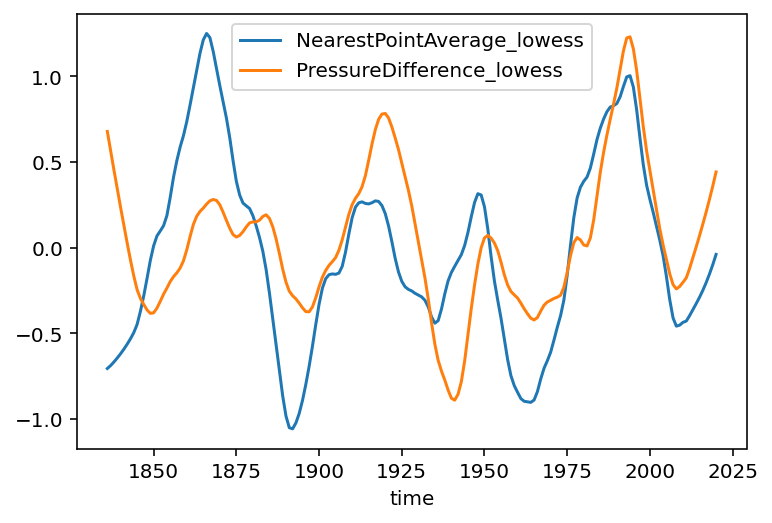

In [198]:
wind_rec[['NearestPointAverage_lowess', 'PressureDifference_lowess']].plot()

## Prepare figures paper

### Evaluation of statistical model

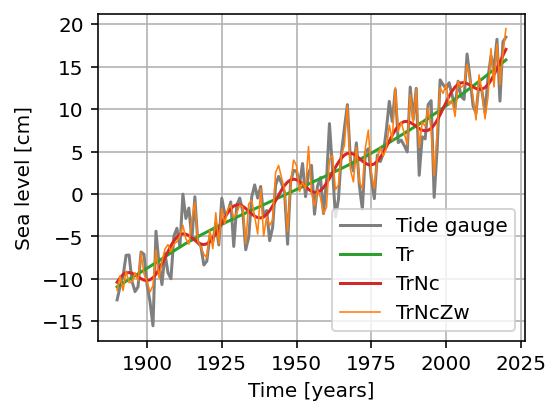

In [365]:
fig, ax = plt.subplots(1, 1, figsize=(4,3)) #14,5

panels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:blue']

tg_df['Average'].plot(label='Tide gauge', color='tab:grey')
res_nr.total.plot(label=short_names[0], color=colors[0])
res_nt.total.plot(label=short_names[1], color=colors[1])
res_na.total.plot(label=short_names[2], color=colors[2], linewidth=0.8)

ax.set_ylabel('Sea level [cm]')
ax.grid(True)
ax.set_xlabel('Time [years]')
#ax.text(0.01, 0.92, panels[idx], transform=ax.flat[idx].transAxes, size=14)

ax.legend(loc='lower right')

    
fig.tight_layout()

#plt.savefig(f'./figures/{method}_TideGauge_StatModels.pdf', dpi=150)

### Wind contribution to sea level

In [324]:
# Estimate the linear trend for different periods

mid_point = int(len(wind_rec.index)/2)

lin_trend_na1 = round(linregress(wind_rec.index[0:mid_point], 
                                 wind_rec['NearestPointAverage_trend'].iloc[0:mid_point]).slope*10, 2)
lin_trend_na2 = round(linregress(wind_rec.index[mid_point:-1], 
                                 wind_rec['NearestPointAverage_trend'].iloc[mid_point:-1]).slope*10, 2)

lin_trend_pd1 = round(linregress(wind_rec.index[0:mid_point], 
                                 wind_rec['PressureDifference_trend'].iloc[0:mid_point]).slope*10, 2)
lin_trend_pd2 = round(linregress(wind_rec.index[mid_point:-1], 
                                 wind_rec['PressureDifference_trend'].iloc[mid_point:-1]).slope*10, 2)


In [325]:
lin_trend_na1, lin_trend_na2, lin_trend_pd1, lin_trend_pd2

(0.15, 0.12, 0.42, 0.15)

In [326]:
# Standard error in the estimation of the linear trend

lin_trend_se_na1 = round(linregress(wind_rec.index[0:mid_point], 
                                 wind_rec['NearestPointAverage_trend'].iloc[0:mid_point]).stderr*10, 3)
lin_trend_se_na2 = round(linregress(wind_rec.index[mid_point:-1], 
                                 wind_rec['NearestPointAverage_trend'].iloc[mid_point:-1]).stderr*10, 3)

lin_trend_se_pd1 = round(linregress(wind_rec.index[0:mid_point], 
                                 wind_rec['PressureDifference_trend'].iloc[0:mid_point]).stderr*10, 3)
lin_trend_se_pd2 = round(linregress(wind_rec.index[mid_point:-1], 
                                 wind_rec['PressureDifference_trend'].iloc[mid_point:-1]).stderr*10, 3)

In [327]:
lin_trend_se_na1, lin_trend_se_na2, lin_trend_se_pd1, lin_trend_se_pd2

(0.0, 0.001, 0.01, 0.003)

These standard errors are very small. The uncertainty in estimating the trend in wind influence on sea level does not come from fitting a linear trend to a wind time series (which these standard errors measure), it comes from the wind data and the method itself. 

Therefore the uncertainty is better estimated by looking at the difference between two methods which we do in the paper.

<ipython-input-366-263fb21fcc90>:33: RuntimeWarning: divide by zero encountered in true_divide
  xf_p = 1/xf_mtm


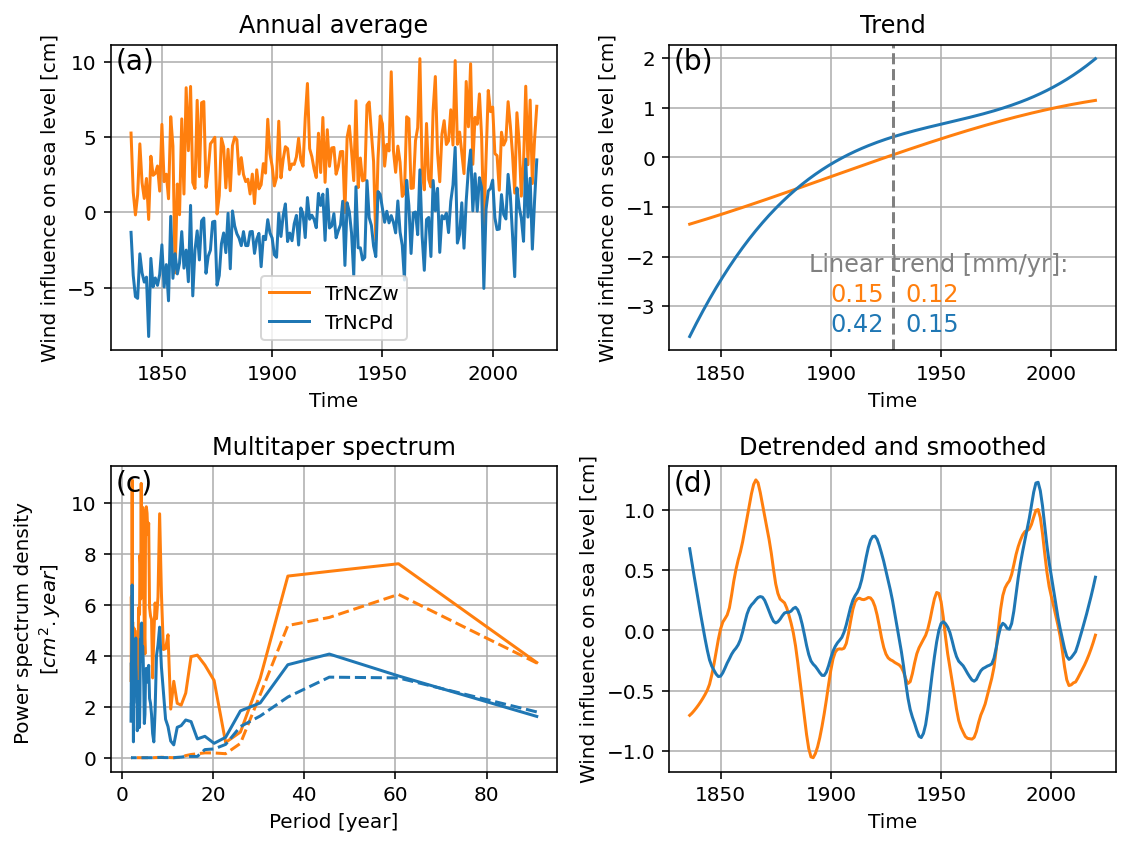

In [366]:
fig, ax = plt.subplots(2, 2, figsize=(8,6)) #14, 10

# Panel 1
wind_rec[['NearestPointAverage', 'PressureDifference']].plot(ax=ax[0,0], color=[colors[2], colors[3]])

ax[0,0].legend(['TrNcZw', 'TrNcPd'])
ax[0,0].set_title('Annual average')
ax[0,0].set_ylabel('Wind influence on sea level [cm]')
ax[0,0].set_xlabel('Time')

# Panel 2
(wind_rec['NearestPointAverage_trend']-wind_rec['NearestPointAverage_trend'].mean() ).plot(ax=ax[0,1], color=colors[2])
(wind_rec['PressureDifference_trend']-wind_rec['PressureDifference_trend'].mean() ).plot(ax=ax[0,1], color=colors[3])                                                                                                          

ax[0,1].text(1900, -2.9, lin_trend_na1, size=12, color=colors[2])
ax[0,1].text(1934, -2.9, lin_trend_na2, size=12, color=colors[2])

ax[0,1].text(1900, -3.5, lin_trend_pd1, size=12, color=colors[3])
ax[0,1].text(1934, -3.5, lin_trend_pd2, size=12, color=colors[3])

ax[0,1].text(1890, -2.3, 'Linear trend [mm/yr]:', size=12, color='grey')

ax[0,1].axvline(x=wind_rec.index[mid_point], color='grey', linestyle='--')

ax[0,1].set_title('Trend')
ax[0,1].set_ylabel('Wind influence on sea level [cm]')
ax[0,1].set_xlabel('Time')

# Panel 3
xf_mtm, yf_mtm, _ = mtm(wind_rec['NearestPointAverage_dt'].values, 1)

# Change x-axis from freqency to period
xf_p = 1/xf_mtm
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='NPA', color=colors[2])

xf_mtm, yf_mtm, _ = mtm(wind_rec['NearestPointAverage_lowess'].values, 1)
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='NPA', color=colors[2], linestyle = 'dashed')

xf_mtm, yf_mtm, _ = mtm(wind_rec['PressureDifference_dt'].values, 1)
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='PD', color=colors[3])

xf_mtm, yf_mtm, _ = mtm(wind_rec['PressureDifference_lowess'].values, 1)
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='PD', color=colors[3], linestyle = 'dashed')

ax[1,0].set_title('Multitaper spectrum')
ax[1,0].set_ylabel('Power spectrum density \n'+r'$[cm^2.year]$')
ax[1,0].set_xlabel('Period [year]')

# Panel 4
wind_rec[['NearestPointAverage_lowess', 'PressureDifference_lowess']].plot(ax=ax[1,1], color=[colors[2], colors[3]])

ax[1,1].set_title('Detrended and smoothed')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('Wind influence on sea level [cm]')

ax[1,1].get_legend().remove()

for idx in range(4):
    ax.flat[idx].text(0.01, 0.92, panels[idx], 
                      transform=ax.flat[idx].transAxes, size=14)
    ax.flat[idx].grid(True)

fig.tight_layout()

#plt.savefig(f'./figures/{method}_WindInfluenceComp_lowess21.pdf', dpi=150)

From Parseval's theorem it follows that the variance (average power) of a process is equal to integrating the power spectrum over all frequency.

$P = Var ⁡ ( x ) = \int_{-\infty}^{\infty}{S_{xx}(f)\,df} $



In [351]:
xf_mtm, yf_mtm, _ = mtm(wind_rec['NearestPointAverage_dt'].values, 1)

print('Variance of signal [cm**2]')
print(np.var(wind_rec['NearestPointAverage_dt']))

print('Sum of the spectral coefficients:')
N = 0.5 # Niquist frequency
df = N/len(yf_mtm)

print(2*np.sum(yf_mtm)*df) # Factor 2 because we kept only half of the spectrum since it is symmetric.

Variance of signal [cm**2]
5.013848290753358
Sum of the spectral coefficients:
5.035436921759868


### Rate of sea level rise

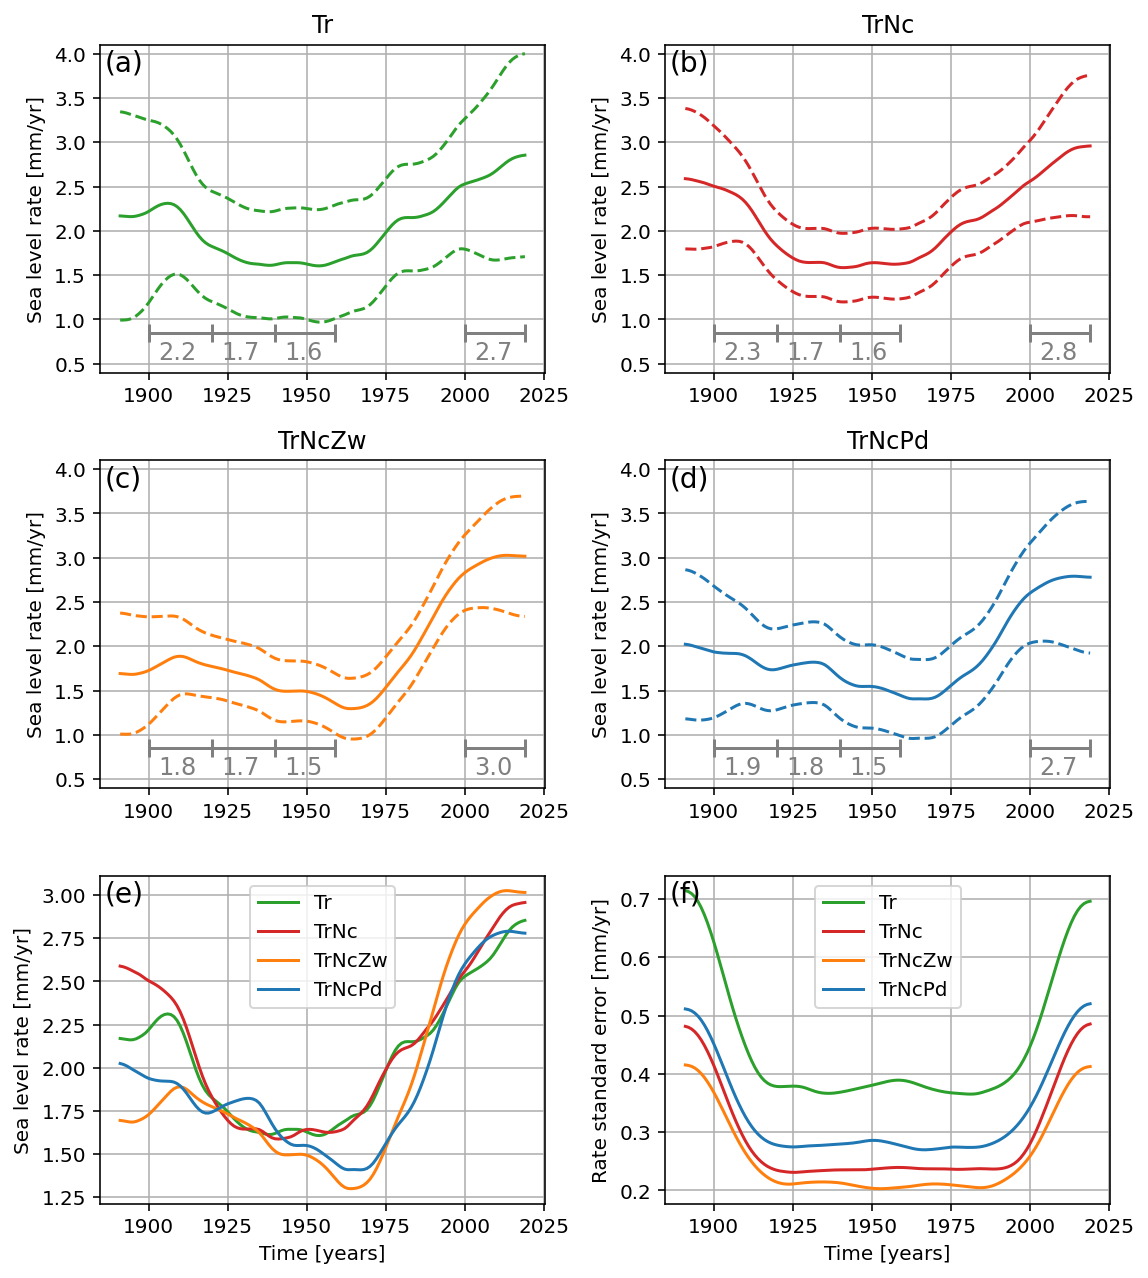

In [273]:
list_st = [1900, 1920, 1940, 2000]

fig, ax = plt.subplots(3, 2, figsize=(8,9))

for idx, res in enumerate([rates_q_nr, rates_q_nt, rates_q_na, rates_q_pd]):
    
    res[0.50].plot(ax=ax.flat[idx], title=short_names[idx], color=colors[idx])
    res[0.05].plot(ax=ax.flat[idx], linestyle='dashed', 
                                          color=colors[idx])
    res[0.95].plot(ax=ax.flat[idx], linestyle='dashed', 
                                          color=colors[idx])
    
    ax.flat[idx].set_xlabel('')
    ax.flat[idx].set_ylabel('Sea level rate [mm/yr]')
    ax.flat[idx].set_ylim([0.4, 4.1])
    ax.flat[idx].grid(True)
    ax.flat[idx].text(0.01, 0.92, panels[idx], transform=ax.flat[idx].transAxes, size=14)
    
    ax.flat[idx].hlines(y=0.85, xmin=list_st[0], xmax=list_st[2]+19, color='grey', linestyle='-')
    ax.flat[idx].hlines(y=0.85, xmin=list_st[3], xmax=list_st[3]+19, color='grey', linestyle='-')
    
    for st in list_st:
        avg_rate = round(res.loc[st:st+19,0.5].mean(axis=0),1)
        ax.flat[idx].text(st+3, 0.55, avg_rate, size=12, color='grey')
        ax.flat[idx].vlines(x=st, ymin=0.75, ymax=0.95, color='grey', linestyle='-')
    
    for st in list_st[2:]:
        ax.flat[idx].vlines(x=st+19, ymin=0.75, ymax=0.95, color='grey', linestyle='-')

rates_q_nr[0.50].plot(ax=ax.flat[4], color=colors[0], label=short_names[0])
rates_q_nt[0.50].plot(ax=ax.flat[4], color=colors[1], label=short_names[1])
rates_q_na[0.50].plot(ax=ax.flat[4], color=colors[2], label=short_names[2])
rates_q_pd[0.50].plot(ax=ax.flat[4], color=colors[3], label=short_names[3])

ax.flat[4].set_ylabel('Sea level rate [mm/yr]')
ax.flat[4].set_xlabel('Time [years]')
ax.flat[4].legend()
ax.flat[4].grid(True)
ax.flat[4].text(0.01, 0.92, panels[4], transform=ax.flat[4].transAxes, size=14)

ser_nr.plot(ax=ax.flat[5], color=colors[0], label=short_names[0])
ser_nt.plot(ax=ax.flat[5], color=colors[1], label=short_names[1])
ser_na.plot(ax=ax.flat[5], color=colors[2], label=short_names[2])
ser_pd.plot(ax=ax.flat[5], color=colors[3], label=short_names[3])

ax.flat[5].set_ylabel('Rate standard error [mm/yr]')
ax.flat[5].set_xlabel('Time [years]')
ax.flat[5].legend()
ax.flat[5].grid(True)
ax.flat[5].text(0.01, 0.92, panels[5], transform=ax.flat[5].transAxes, size=14)
    
fig.tight_layout()
plt.savefig(f'./figures/{method}_RateSeaLevelTrend.pdf', dpi=150)

Print the rate numbers and uncertainty range

In [372]:
print('Format: Median [0.05, 0.095]')

for idx, res in enumerate([rates_q_nr, rates_q_nt, rates_q_na, rates_q_pd]):
    print('')
    print(f'Model: {short_names[idx]}')
    
    for st in list_st:
        avg_rate = round(res.loc[st:st+19,0.5].mean(axis=0),1)
        low_bound = round(res.loc[st:st+19,0.05].mean(axis=0),1)
        high_bound = round(res.loc[st:st+19,0.95].mean(axis=0),1)
        
        print(f'Period: {st}-{st+19}')
        print(f'{avg_rate} [{low_bound},{high_bound}]')
        
        

Format: Median [0.05, 0.095]

Model: Tr
Period: 1900-1919
2.2 [1.4,2.9]
Period: 1920-1939
1.7 [1.1,2.3]
Period: 1940-1959
1.6 [1.0,2.3]
Period: 2000-2019
2.7 [1.7,3.7]

Model: TrNc
Period: 1900-1919
2.3 [1.8,2.8]
Period: 1920-1939
1.7 [1.3,2.1]
Period: 1940-1959
1.6 [1.2,2.0]
Period: 2000-2019
2.8 [2.1,3.5]

Model: TrNcZw
Period: 1900-1919
1.8 [1.4,2.3]
Period: 1920-1939
1.7 [1.3,2.0]
Period: 1940-1959
1.5 [1.1,1.8]
Period: 2000-2019
3.0 [2.4,3.5]

Model: TrNcPd
Period: 1900-1919
1.9 [1.3,2.4]
Period: 1920-1939
1.8 [1.3,2.2]
Period: 1940-1959
1.5 [1.1,2.0]
Period: 2000-2019
2.7 [2.0,3.5]


In [367]:
rates_q_nr

,0.05,0.17,0.50,0.83,0.95
time,,,,,
1890,NaN,NaN,NaN,NaN,NaN
1891,0.993479,1.487048,2.168899,2.850751,3.344320
1892,0.993677,1.486079,2.166317,2.846554,3.338956
1893,0.996153,1.486171,2.163114,2.840058,3.330075
1894,1.003227,1.489352,2.160919,2.832486,3.318611
...,...,...,...,...,...
2016,1.700171,2.174803,2.830493,3.486183,3.960815
2017,1.702984,2.181031,2.841437,3.501844,3.979890
2018,1.706351,2.186410,2.849596,3.512783,3.992842


### Compute the percentages for the paper

Deviance

In [295]:
resm_df.Deviance

Statistical model
Tr : Trend only                                   1167.0
TrNc : Trend and nodal tide                       1031.0
TrNcZw : Trend, nodal tide and wind (velocity)     428.0
TrNcPd : Trend, nodal tide and wind (pressure)     652.0
Name: Deviance, dtype: float64

In [304]:
round(100-100*resm_df.Deviance[1]/resm_df.Deviance[0],0)

12.0

In [305]:
round(100-100*resm_df.Deviance[2]/resm_df.Deviance[1],0)

58.0

In [306]:
round(100-100*resm_df.Deviance[3]/resm_df.Deviance[1],0)

37.0